# Create Investment_Pod Groups

POD Time Series Graph | Project 3
Goal: Inferring relationships between the investment_pods using the correlation between their weekly_returns. 

Nodes: Investment_Pod and Pod_Trading_Day
Relationship:  Trading_Day, Next_Day
Labels:  Pod_id, date, weekly_return 

Steps
- Before running this notebook, the following notebooks need to have been run in order:
    - 1_Data_Wrangling_Extract_Workbook.ipynb
    - 2_Data_Wrangling_Load_CSV.ipynb
    - 2_1_Data_Wrangling_Create_Pod_Return_From_NAV_History.ipynb
    - 3_Create_Time_series_Graph_Database.ipynb

- Setup Cursors and connection to Containers
- Run the Pearson Similarity Correlation Algorithm to create similarity pairs between the weekly returns of the investment_pods
- Run the Louvain Moularity Algorithm to identify community of pods 
- Calculate the slope of the weekly_return for each trading_day for each investment_pod. 
- Run the Linear Regression using the Louvain Modularity and the weekly_return slopes to identify groups that have similar rise and fall of the weekly_returns. 
- View Graph in Neo4j Browser

In [1]:
import neo4j


import math
import numpy as np
import pandas as pd

import psycopg2
import warnings
warnings.filterwarnings('ignore')

In [2]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))

In [3]:
session = driver.session(database="neo4j")

## Inferring relationships based on the correlation coefficient
First create the graph projection. Then, we will calculate the Pearson similarity coefficient

In [4]:
def my_neo4j_create_projection():
    "create graph projection "
    
    query = "CALL gds.graph.drop('ds_graph', false) yield graphName"
    session.run(query)

    query = "CALL gds.graph.project('ds_graph', 'Investment_Pod', '*', {nodeProperties:'return_array'})   YIELD *"
    session.run(query)
    
    

In [5]:
def my_neo4j_create_pearson_similarity_pairs():
    "create similarity pairs using Pearson correlation"
    
    query = """

    MATCH (s:Investment_Pod)
    WITH {item:id(s), weights: s.return_array} AS podData
    WITH collect(podData) AS input
    CALL gds.knn.write('ds_graph', {
        writeRelationshipType: 'SIMILAR',
        writeProperty: 'score',
        topK: 3,
        similarityCutoff:0.2,
        nodeProperties:{return_array:'Pearson'}
    }) 
    YIELD  nodesCompared, relationshipsWritten
    RETURN nodesCompared, relationshipsWritten

    """
    
    session.run(query)

In [6]:
my_neo4j_create_projection()

In [7]:
my_neo4j_create_pearson_similarity_pairs()

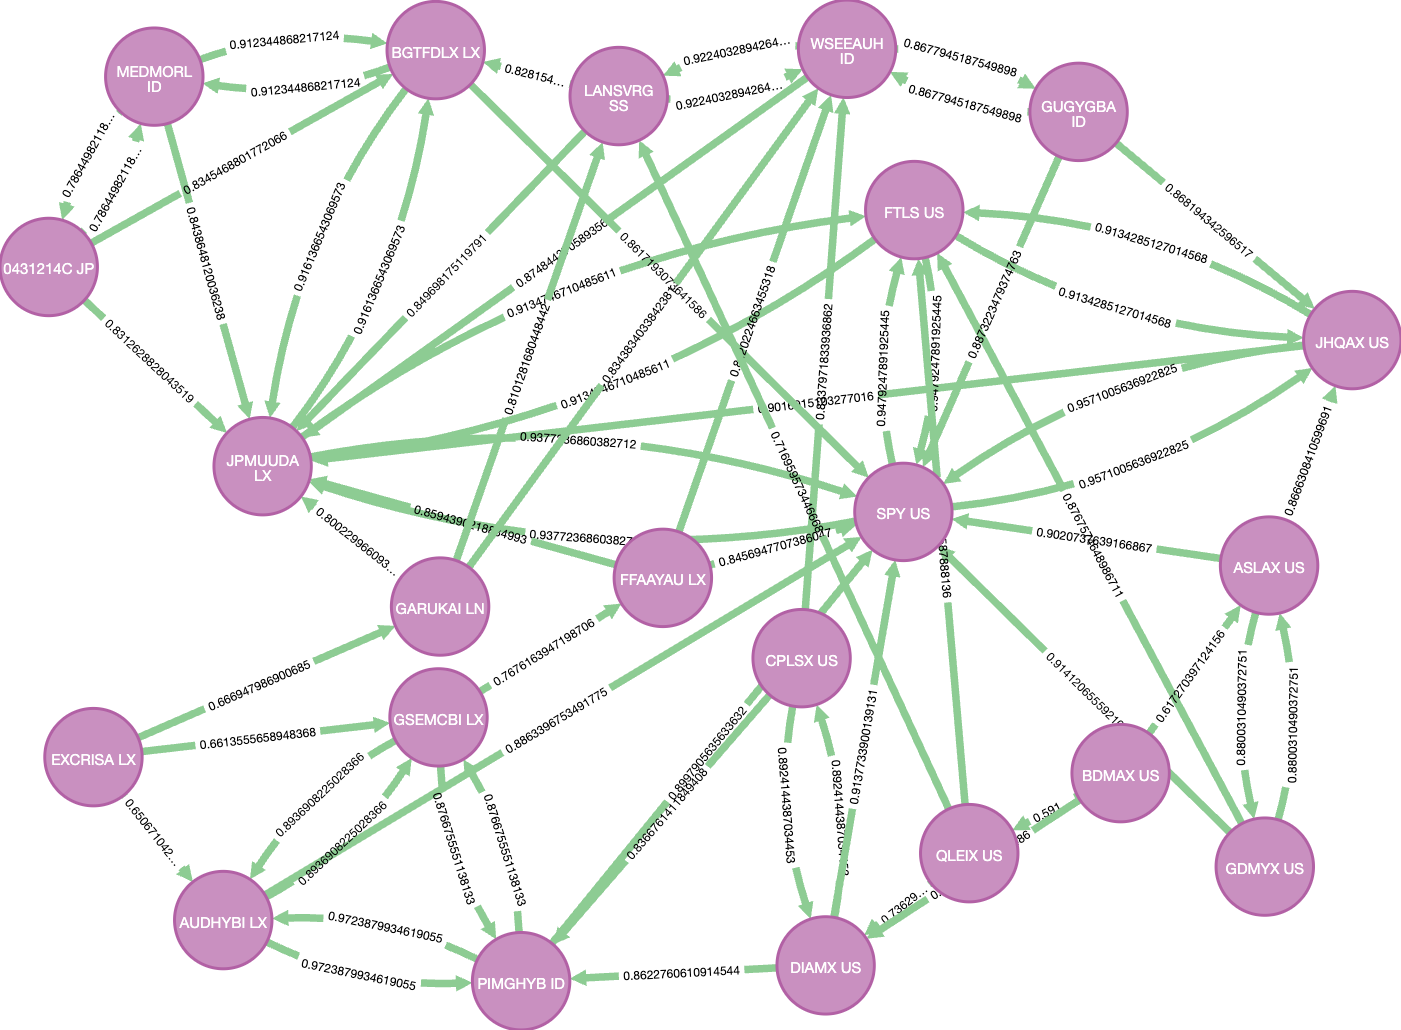

Pearson Similarity Pairs using the following query: 
match (a)-[r:SIMILAR]->(b) return a, b , r.score order by r.score desc limit 100


### Louvain Modularity


In [ ]:
""" Create the graph projection
"""
query = "CALL gds.graph.drop('ds_graph', false) yield graphName"
session.run(query)

query = """

CALL gds.graph.project('ds_graph', 'Investment_Pod', 'SIMILAR', 
                      {nodeProperties: 'return_array', relationshipProperties: 'score'})

"""
result = session.run(query)
df = pd.DataFrame(result)
df

In [9]:
""" Query to write the community count and modularity in the database.
"""
query = """

CALL gds.louvain.write('ds_graph', { writeProperty: 'louvain' })
YIELD communityCount, modularity, modularities

"""
result = session.run(query)
df = pd.DataFrame(result)
df

,0,1,2
0,4,0.407713,[0.40771349862258954]


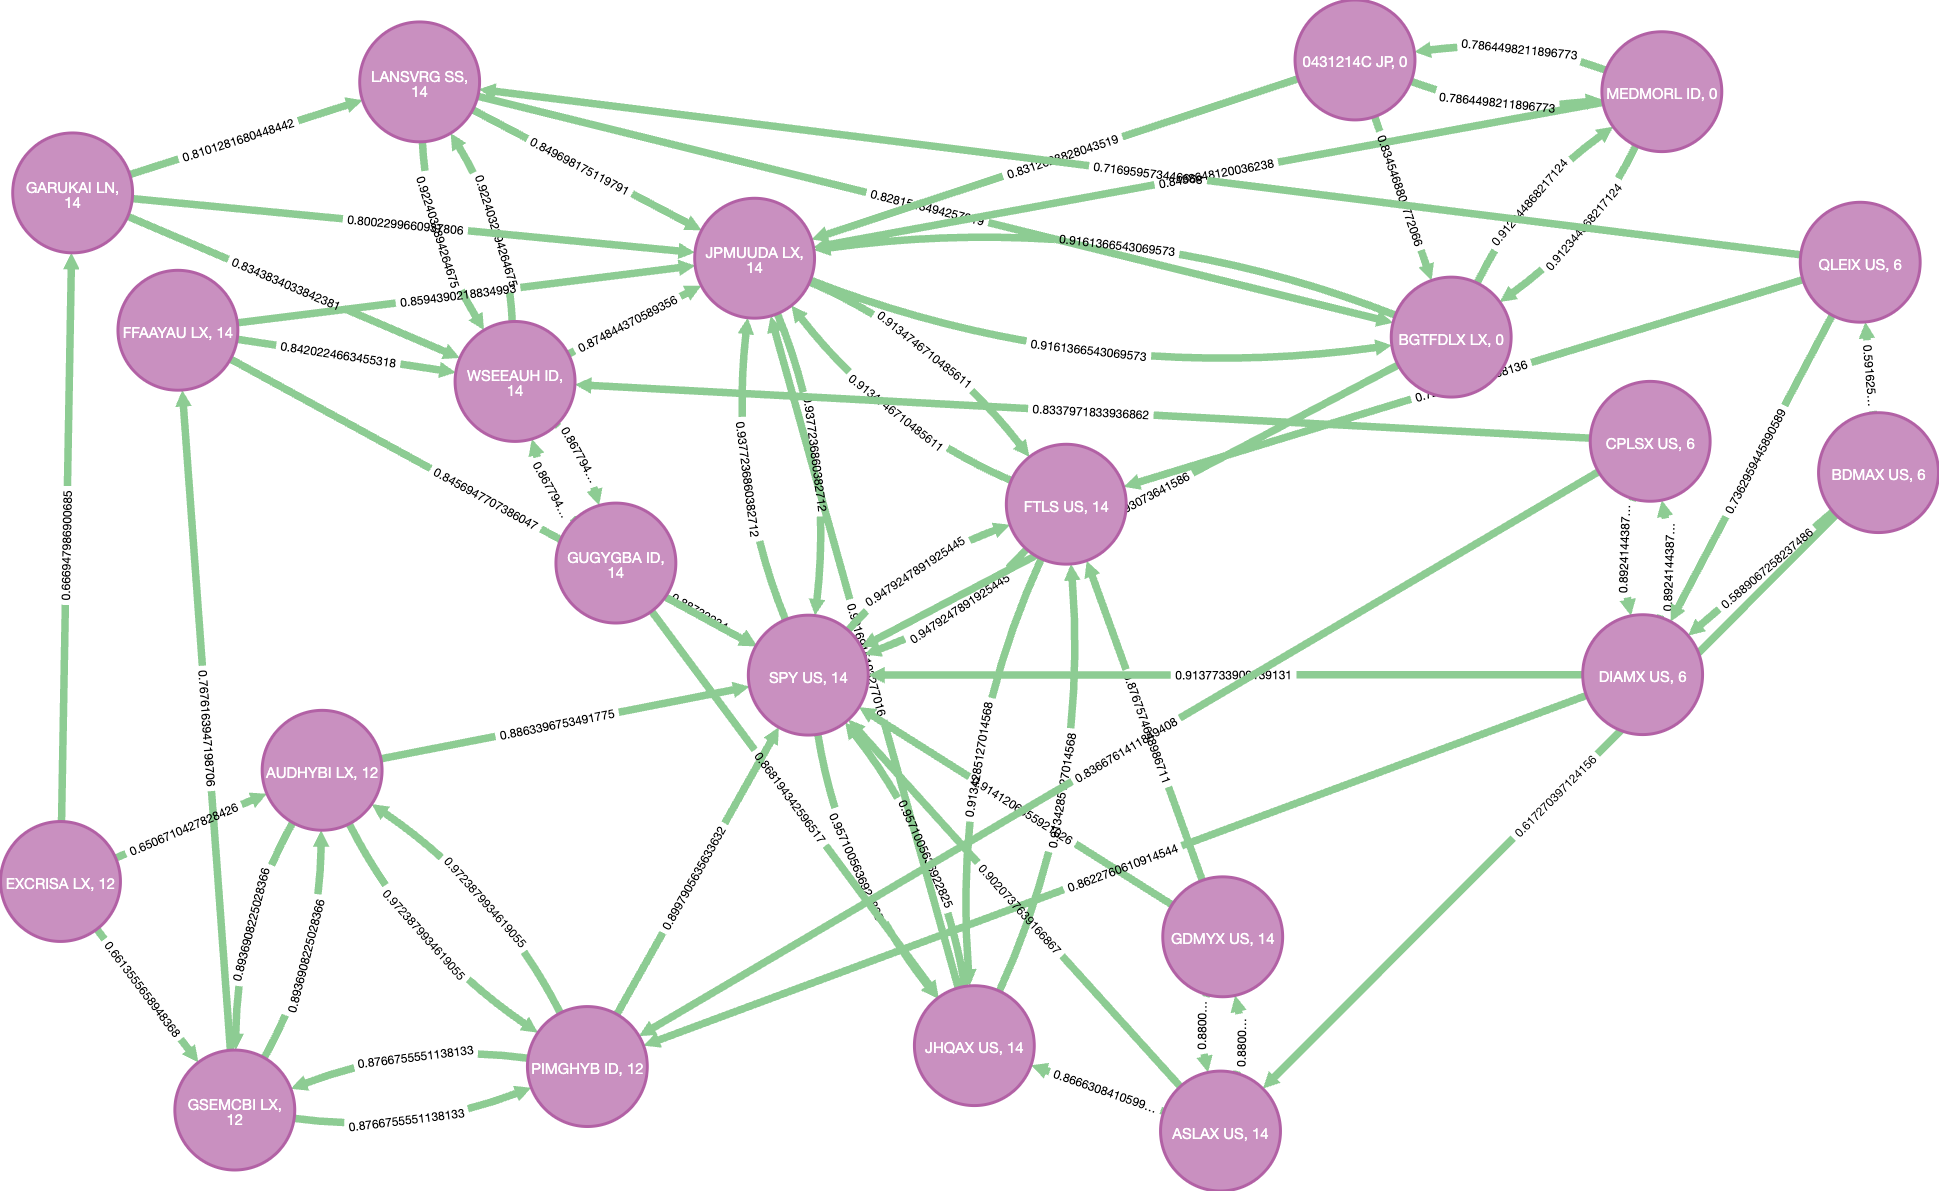

## Implement Linear Regression

This query Identifies all 'Trading_Day' relations connected to each 'Investment_pod' nodes.
For each identified 'Trading Day' node, it adds a new label to it.
The new label is dynamically determined by the 'name' property of the connected 'Investment_Pod' node. This is needed to use the linear regression function.  

In [10]:
query = """

MATCH (s:Investment_Pod)-[:TRADING_DAY]->(day)
WITH s, day
CALL apoc.create.addLabels( day, [s.name]) YIELD node
RETURN distinct 'done'

"""
result = session.run(query)
df = pd.DataFrame(result)
df

,0
0,done


This query finds all Investment_pod nodes and their associated trading days. From those trading days, it identifies the earliest trading day that doesn't have a previous trading day linked by a NEXT_DAY relationship. Then, starting from that initial trading day, it traverses forward through all subsequent trading days (connected by NEXT_DAY relationships), and assigns an index property to each of those trading days, representing their position in the sequence (0 for the start, 1 for the next, and so on). 

In [ ]:
query = """

MATCH (s:Investment_Pod)-[:TRADING_DAY]->(day)
WHERE NOT ()-[:NEXT_DAY]->(day)
MATCH p=(day)-[:NEXT_DAY*0..]->(next_day)
SET next_day.index = length(p)

"""
result = session.run(query)
df = pd.DataFrame(result)
df

This Cypher query finds all nodes labeled "Investment_Pod", calculates the slope of a linear regression between their 'weekly_return' and 'index' properties using the APOC library, and then stores that calculated slope value as a new property called 'slope' on each individual "Investment_Pod" node. 

In [ ]:
query = """

MATCH (s:Investment_Pod)
CALL apoc.math.regr(s.name, 'weekly_return', 'index') YIELD slope
SET s.slope = slope;

"""
result = session.run(query)
df = pd.DataFrame(result)
df

In [22]:
""" Using the Louvain community and weekly_return slopes identify potential investments groups
"""

query = """

MATCH (s:Investment_Pod)
WITH s.louvain AS community, s.slope AS slope, s.name AS ticker
ORDER BY slope DESC
RETURN community, collect(ticker)[..7] as potential_investments

"""

result = session.run(query)
df = pd.DataFrame(result)
df

,0,1
0,14,"[WSEEAUH ID, JPMUUDA LX, SPY US, LANSVRG SS, G..."
1,0,"[0431214C JP, BGTFDLX LX, MEDMORL ID]"
2,18,"[QLEIX US, CPLSX US, BDMAX US, DIAMX US]"
3,12,"[AUDHYBI LX, PIMGHYB ID, GSEMCBI LX, EXCRISA LX]"
